In [9]:
from matplotlib import pyplot as plt
import sys

sys.path.append('../..')
from model.amm.omnipool_router import OmnipoolRouter
from model.amm.stableswap_amm import StableSwapPoolState
from model.amm.stableswap_amm import simulate_swap as simulate_stableswap_swap
from model.amm.omnipool_amm import OmnipoolState, DynamicFee
from model.amm.agents import Agent

# try again... add silly test comment


In [2]:
lrna_price = 25  # price of LRNA in USDT
current_omnipool_liquidity = {'HDX': 85_500_000, '2-Pool': 15_000_000,
                      'DOT': 2_717_000, 'vDOT': 905_800,
                      'WETH': 905.5, 'ASTR': 50_080_000,
                      'GLMR': 14_080_000, '4-Pool': 1_265_000,
                      'BNC': 5_972_000, 'tBTC': 10.79,
                      'CFG': 5_476_000, 'iBTC': 10.42,
                      'WBTC': 10.29, 'PHA': 5_105_000,
                      'KSM': 32_790, 'INTR': 67_330_000,
                      'vASTR': 7_165_000, 'KILT': 4_490_000,
                      'AAVE': 965.4, 'SOL': 754.4,
                      'ZTG': 8_229_000, 'CRU': 442_600,
                      '2-Pool-Btc': 0.6296, 'RING': 32_760_000}

usd_values = {'HDX': 1_000_000, '2-Pool': 15_000_000, 'DOT': 13_250_000,
              'vDOT': 6_475_000, 'WETH': 2_050_000, 'ASTR': 1_900_000,
              'GLMR': 1_660_000, '4-Pool': 1_290_000, 'BNC': 1_085_000,
              'tBTC': 900_000, 'CFG': 870_000, 'iBTC': 870_000,
              'WBTC': 860_000, 'PHA': 760_000, 'KSM': 640_000,
              'INTR': 370_000, 'vASTR': 320_000, 'KILT': 250_000,
              'AAVE': 190_000, 'SOL': 100_000, 'ZTG': 94_000,
              'CRU': 71_000, '2-Pool-Btc': 55_000, 'RING': 47_000}

lrna_amounts = {key: value / lrna_price for key, value in usd_values.items()}

tokens = {
    tkn: {'liquidity': current_omnipool_liquidity[tkn], 'LRNA': lrna_amounts[tkn]}
    for tkn in current_omnipool_liquidity
}

lrna_fee = DynamicFee(
    minimum=0.0005, maximum=0.0010, amplification=1,
    decay=0.000001
)
asset_fee = DynamicFee(
    minimum=0.0025, maximum=0.01, amplification=2,
    decay=0.00001
)

omnipool = OmnipoolState(
    tokens=tokens, lrna_fee=lrna_fee, asset_fee=asset_fee
)

In [3]:
tokens_2_pool = {'USDT': 9_000_000, 'USDC': 8_000_000}
ss_2_pool = StableSwapPoolState(
    tokens=tokens_2_pool, amplification=100, trade_fee=0.0002, unique_id='2-Pool'
)
tokens_4_pool = {
    'USDT': 362000, 'USDC2': 262000,
    'DAI': 368000, 'USDT2': 323000
}
ss_4_pool = StableSwapPoolState(
    tokens=tokens_4_pool, amplification=320, trade_fee=0.0002, unique_id='4-Pool'
)

In [4]:
exchanges = {'omnipool': omnipool, '2-Pool': ss_2_pool, '4-Pool': ss_4_pool}
router = OmnipoolRouter(exchanges=exchanges)

In [5]:
print(omnipool.liquidity)
print(ss_2_pool.liquidity)
print(ss_4_pool.liquidity)

{'HDX': 85500000, '2-Pool': 15000000, 'DOT': 2717000, 'vDOT': 905800, 'WETH': 905.5, 'ASTR': 50080000, 'GLMR': 14080000, '4-Pool': 1265000, 'BNC': 5972000, 'tBTC': 10.79, 'CFG': 5476000, 'iBTC': 10.42, 'WBTC': 10.29, 'PHA': 5105000, 'KSM': 32790, 'INTR': 67330000, 'vASTR': 7165000, 'KILT': 4490000, 'AAVE': 965.4, 'SOL': 754.4, 'ZTG': 8229000, 'CRU': 442600, '2-Pool-Btc': 0.6296, 'RING': 32760000}
{'USDT': 9000000, 'USDC': 8000000}
{'USDT': 362000, 'USDC2': 262000, 'DAI': 368000, 'USDT2': 323000}


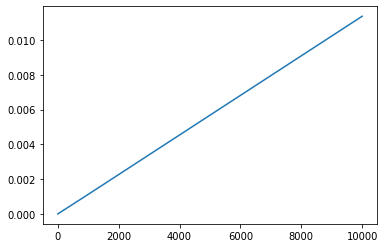

In [6]:
agent = Agent(enforce_holdings=False)
buy_sizes = [1, 10, 100, 1000, 10000]
buy_sizes.sort()
sell_amts = []
for buy_size in buy_sizes:
    new_state, new_agent = router.simulate_swap(
        agent, tkn_buy='DOT', tkn_sell='vDOT', buy_quantity=buy_size
    )
    sell_amts.append(-new_agent.get_holdings('vDOT'))
prices = [sell_amts[i] / buy_sizes[i] for i in range(len(buy_sizes))]
lowest_price = prices[0]
slippage = [(prices[i]  - lowest_price) / lowest_price for i in range(len(buy_sizes))]

plt.plot(buy_sizes, slippage)

In [7]:
usd_value_vdot = usd_values['vDOT']
usd_value_dot = usd_values['DOT']
tokens_gigadot_pool = {
    'vDOT': current_omnipool_liquidity['vDOT'] * 2/3,
    'DOT': current_omnipool_liquidity['DOT'] * usd_value_vdot / usd_value_dot * 2/3,
    'aDOT': current_omnipool_liquidity['DOT'] * usd_value_vdot / usd_value_dot * 2/3,
}
gigadot_pool = StableSwapPoolState(
    tokens=tokens_gigadot_pool, amplification=100, trade_fee=0.0002, unique_id='gigaDOT'
)

omnipool_gigadot_tokens = {tkn: value for tkn, value in current_omnipool_liquidity.items()}
omnipool_gigadot_tokens['DOT'] -= current_omnipool_liquidity['DOT'] * usd_value_vdot / usd_value_dot
del omnipool_gigadot_tokens['vDOT']

tokens = {
    tkn: {'liquidity': omnipool_gigadot_tokens[tkn], 'LRNA': lrna_amounts[tkn]}
    for tkn in omnipool_gigadot_tokens
}

lrna_fee = DynamicFee(
    minimum=0.0005, maximum=0.0010, amplification=1,
    decay=0.000001
)
asset_fee = DynamicFee(
    minimum=0.0025, maximum=0.01, amplification=2,
    decay=0.00001
)

omnipool_gigadot = OmnipoolState(
    tokens=tokens, lrna_fee=lrna_fee, asset_fee=asset_fee
)

exchanges = {'omnipool': omnipool_gigadot, '2-Pool': ss_2_pool, '4-Pool': ss_4_pool, 'gigaDOT': gigadot_pool}
router_gigadot = OmnipoolRouter(exchanges=exchanges)

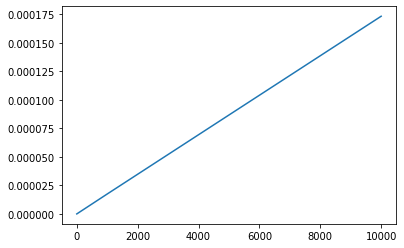

In [8]:
agent = Agent(enforce_holdings=False)
sell_amts = []
for buy_size in buy_sizes:
    new_state, new_agent = simulate_stableswap_swap(
        gigadot_pool, agent, tkn_buy='DOT', tkn_sell='vDOT', buy_quantity=buy_size
    )
    sell_amts.append(-new_agent.get_holdings('vDOT'))
prices = [sell_amts[i] / buy_sizes[i] for i in range(len(buy_sizes))]
lowest_price = prices[0]
slippage = [(prices[i]  - lowest_price) / lowest_price for i in range(len(buy_sizes))]

plt.plot(buy_sizes, slippage)